
git hub https://github.com/LeonelAvVi/InteligenciaII.git

carpeta de Dataset: https://drive.google.com/drive/folders/14MZNuZg5xmbKtR3L9Wq_Tdwu9eyNliL6?usp=sharing

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cp -av /content/drive/MyDrive/universidad/inteligencia2/lab3/dataset_flores /content/dataImg


'/content/drive/MyDrive/universidad/inteligencia2/lab3/dataset_flores' -> '/content/dataImg'


In [5]:
import os
path ='/content/dataImg/'
directorio = os.listdir(path)
directorio

['tagetes', 'Hibisco', 'FlorRita', 'claveles', 'lirio', 'Girasoles', 'rosas']

In [6]:
labels_def = {'tagetes':0, 'Hibisco':1, 'Girasoles':2,'FlorRita':3,'claveles':4, 'lirio':5,'rosas':6}
labels_def

{'FlorRita': 3,
 'Girasoles': 2,
 'Hibisco': 1,
 'claveles': 4,
 'lirio': 5,
 'rosas': 6,
 'tagetes': 0}

In [7]:
import numpy as np
images =[]
labels = []
for d in directorio:
   imagenes = os.listdir(path + d)
   for i in imagenes:
       imgPath2 = path + d + '/' + i
       images.append(imgPath2)
       labels.append(labels_def[d])

In [8]:
X_train = images
labels_train = labels

In [9]:
def getName(label):
  for key in labels_def:
      if labels_def[key] == label:
        return(key)

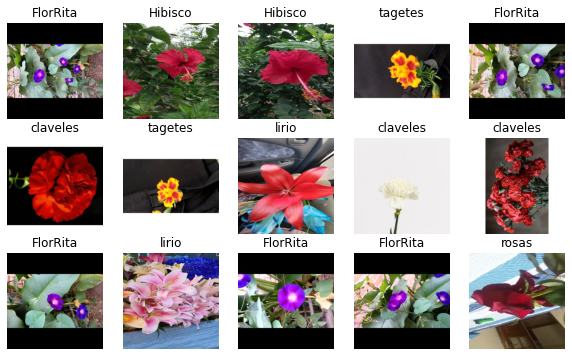

In [10]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(X_train)-1)
    img = io.imread(X_train[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getName(labels_train[ix]))
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(X_train, labels_train, test_size=0.07, stratify=labels_train)

len(train_imgs), len(test_imgs)

(7229, 545)

In [12]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    # self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img1 = Image.open(self.X[ix])
    new_img = img1.resize((32,32))
    #images.append(np.array(new_img)/255)
    return torch.from_numpy((np.array(new_img))/255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [13]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
Xtrain = dataset['train']
XText = dataset['test']
Xtrain

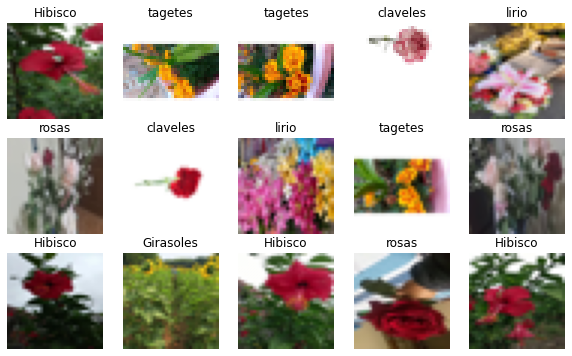

In [14]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getName(lab))
plt.show()

In [15]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 32, 32])

In [16]:
import torchvision

mobilenet = torchvision.models.mobilenet_v2()
mobilenet

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [17]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos mobilenet
    mobilenet = torchvision.models.mobilenet_v2(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.mobilenet = torch.nn.Sequential(*list(mobilenet.children())[:-1])
    if freeze:
      for param in self.mobilenet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1280, 7)

  def forward(self, x):
    x = self.mobilenet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.mobilenet.parameters():
        param.requires_grad=True

In [18]:
model = Model()
outputs = model(torch.randn(64, 3, 32, 32))
outputs.shape

torch.Size([64, 7])

In [19]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [20]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
model = Model()
fit(model, dataloader, epochs=5)

val_loss 0.53317 val_acc 0.81211: 100%|██████████| 3/3 [01:20<00:00, 26.75s/it]


Epoch 1/5 loss 0.99436 val_loss 0.53317 acc 0.64150 val_acc 0.81211


val_loss 0.26078 val_acc 0.91923: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch 2/5 loss 0.29207 val_loss 0.26078 acc 0.90678 val_acc 0.91923


val_loss 0.15381 val_acc 0.94334: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 3/5 loss 0.15153 val_loss 0.15381 acc 0.95551 val_acc 0.94334


val_loss 0.08516 val_acc 0.97948: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch 4/5 loss 0.09984 val_loss 0.08516 acc 0.97219 val_acc 0.97948


val_loss 0.05113 val_acc 0.98469: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

Epoch 5/5 loss 0.06812 val_loss 0.05113 acc 0.98216 val_acc 0.98469


In [22]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

val_loss 0.50453 val_acc 0.90037: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 1/5 loss 0.85785 val_loss 0.50453 acc 0.77178 val_acc 0.90037


val_loss 0.39280 val_acc 0.90329: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 2/5 loss 0.46697 val_loss 0.39280 acc 0.88005 val_acc 0.90329


val_loss 0.34256 val_acc 0.91241: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 3/5 loss 0.38305 val_loss 0.34256 acc 0.89430 val_acc 0.91241


val_loss 0.29680 val_acc 0.93162: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 4/5 loss 0.33658 val_loss 0.29680 acc 0.91077 val_acc 0.93162


val_loss 0.25906 val_acc 0.95443: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

Epoch 5/5 loss 0.30657 val_loss 0.25906 acc 0.91799 val_acc 0.95443


In [23]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

val_loss 0.49613 val_acc 0.90396: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch 1/5 loss 0.85562 val_loss 0.49613 acc 0.77274 val_acc 0.90396


val_loss 0.37623 val_acc 0.90428: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch 2/5 loss 0.45308 val_loss 0.37623 acc 0.89336 val_acc 0.90428


val_loss 0.29412 val_acc 0.93391: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 3/5 loss 0.36584 val_loss 0.29412 acc 0.90412 val_acc 0.93391


val_loss 0.27884 val_acc 0.94141: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 4/5 loss 0.32702 val_loss 0.27884 acc 0.91547 val_acc 0.94141


val_loss 0.26715 val_acc 0.93292: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

Epoch 5/5 loss 0.30338 val_loss 0.26715 acc 0.92157 val_acc 0.93292


In [24]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-3)

val_loss 0.48255 val_acc 0.90428: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 1/5 loss 0.84970 val_loss 0.48255 acc 0.77304 val_acc 0.90428


val_loss 0.35227 val_acc 0.94042: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 2/5 loss 0.45250 val_loss 0.35227 acc 0.88713 val_acc 0.94042


val_loss 0.31165 val_acc 0.93032: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 3/5 loss 0.38218 val_loss 0.31165 acc 0.90012 val_acc 0.93032


val_loss 0.26975 val_acc 0.95573: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 4/5 loss 0.33376 val_loss 0.26975 acc 0.91144 val_acc 0.95573


val_loss 0.22743 val_acc 0.96484: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 5/5 loss 0.31154 val_loss 0.22743 acc 0.91590 val_acc 0.96484


val_loss 0.12534 val_acc 0.97526: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 1/5 loss 0.22476 val_loss 0.12534 acc 0.93180 val_acc 0.97526


val_loss 0.07150 val_acc 0.98698: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 2/5 loss 0.14075 val_loss 0.07150 acc 0.96003 val_acc 0.98698


val_loss 0.07850 val_acc 0.98307: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 3/5 loss 0.09481 val_loss 0.07850 acc 0.97441 val_acc 0.98307


val_loss 0.03824 val_acc 0.99089: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 4/5 loss 0.06600 val_loss 0.03824 acc 0.98534 val_acc 0.99089


val_loss 0.03625 val_acc 0.99349: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Epoch 5/5 loss 0.04571 val_loss 0.03625 acc 0.99045 val_acc 0.99349
